# Dataset
* A study conducted by Columbia University explored gender differences in dating preferences.

* Participants attended a dating event where they had a 4-minute date with every other participant of the opposite sex who attended the same event.
* The participants decided to accept or reject their partner. If both the participant and partner matched, they received each other's contact information.
* Participants rated their partners on six personal attributes: attractiveness, sincerity, intelligence, fun, ambition and shared interests.
* Before and after the event, participants rated their preferences in the six attributes and gave themselves ratings.
* Other information was collected about the participants' background and preferences.

In [2]:
import numpy as np              # arrays
import pandas as pd             # dataframes
import matplotlib.pyplot as plt # graphs
import seaborn as sns           # visualisations
from scipy import stats         # statistics

In [4]:
from sklearn.experimental import enable_iterative_imputer # enable experimental imputer
from sklearn.impute import IterativeImputer               # sample imputation
from sklearn import preprocessing                         # encoders, transformations
from sklearn.model_selection import cross_validate        # cross-validation, model evaluation
from sklearn.model_selection import GridSearchCV          # hyper-parameter tuning
from sklearn.linear_model import LogisticRegression       # logistic regression model
from sklearn.svm import SVC                               # support vector machine model
from sklearn.neighbors import KNeighborsClassifier        # k-nearest neighbours model
from sklearn.ensemble import GradientBoostingClassifier   # gradient boosting model
from sklearn.ensemble import VotingClassifier             # voting ensemble model
from sklearn.ensemble import StackingClassifier           # stacking ensemble model
%matplotlib inline

# data

In [6]:
data_raw = pd.read_csv(
    filepath_or_buffer='./input/Speed Dating Data.csv',
    engine='python'
)

In [105]:
opp = [col for col in data_raw.columns if "_o" in col]

In [106]:
opp

['age_o',
 'race_o',
 'pf_o_att',
 'pf_o_sin',
 'pf_o_int',
 'pf_o_fun',
 'pf_o_amb',
 'pf_o_sha',
 'dec_o',
 'attr_o',
 'sinc_o',
 'intel_o',
 'fun_o',
 'amb_o',
 'shar_o',
 'like_o',
 'prob_o',
 'met_o',
 'go_out']

In [7]:
data_raw.shape

(8378, 195)

In [110]:
data_raw['pid']

0        11.0
1        12.0
2        13.0
3        14.0
4        15.0
        ...  
8373    526.0
8374    527.0
8375    528.0
8376    529.0
8377    530.0
Name: pid, Length: 8378, dtype: float64

In [9]:
data_raw.tail(5)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8377,552,NaN,1,44,2,21,22,2,10.0,15,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [24]:
data_raw['sports'].value_counts()

8.0     1294
7.0     1185
10.0    1069
9.0     1052
5.0      860
6.0      760
3.0      679
4.0      584
2.0      469
1.0      347
Name: sports, dtype: int64

In [10]:
data_raw.memory_usage().sum()

13069808

## functions

In [13]:
# Define a function to plot distribution functions
def plot_distribution(data, bins, title, xlabel, ylabel):
    ax = sns.distplot(
        data,
        bins=bins,
        hist_kws={
            "linewidth": 1,
            'edgecolor': 'black',
            'alpha': 1.0
            },
        kde=False
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    

# Define a function to plot relationship between two features
def plot_relationship(x, y, title, xlabel, ylabel):
    ax = sns.barplot(
        x=x,
        y=y,
        orient='h'
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
# Define a function to print a feature's mean, standard deviation, skewness and kurtosis
def print_moments(title, feature):
    print(title)
    print('Mean: '+'{:>18.2f}'.format(feature.mean()))
    print('Standard deviation: '+'{:.2f}'.format(feature.std()))
    print('Skewness: '+'{:>14.2f}'.format(feature.skew()))
    print('Kurtosis: '+'{:>14.2f}'.format(feature.kurtosis()))

# Wrangling

* Identify relevant features and associated datatypes



In [14]:
relevant_features = [
    ['iid', 'int16'],
    ['gender', 'bool'],
    ['wave', 'int16'],
    ['position', 'int16'],
    ['order', 'int16'],
    ['pid', 'int16'],
    ['age_o', 'int16'],
    ['race_o', 'category'],
    ['pf_o_att', 'int16'],
    ['pf_o_sin', 'int16'],
    ['pf_o_int', 'int16'],
    ['pf_o_fun', 'int16'],
    ['pf_o_amb', 'int16'],
    ['pf_o_sha', 'int16'],
    ['dec_o', 'bool'],
    ['attr_o', 'int16'],
    ['sinc_o', 'int16'],
    ['intel_o', 'int16'],
    ['fun_o', 'int16'],
    ['amb_o', 'int16'],
    ['shar_o', 'int16'],
    ['like_o', 'int16'],
    ['prob_o', 'int16'],
    ['met_o', 'bool'],
    ['age', 'int16'],
    ['field_cd', 'category'],
    ['race', 'category'],
    ['imprace', 'int16'],
    ['imprelig', 'int16'],
    ['goal', 'category'],
    ['date', 'int16'],
    ['go_out', 'int16'],
    ['career_c', 'category'],
    ['sports', 'int16'],
    ['tvsports', 'int16'],
    ['exercise', 'int16'],
    ['dining', 'int16'],
    ['museums', 'int16'],
    ['art', 'int16'],
    ['hiking', 'int16'],
    ['gaming', 'int16'],
    ['clubbing', 'int16'],
    ['reading', 'int16'],
    ['tv', 'int16'],
    ['theater', 'int16'],
    ['movies', 'int16'],
    ['concerts', 'int16'],
    ['music', 'int16'],
    ['shopping', 'int16'],
    ['yoga', 'int16'],
    ['exphappy', 'int16'],
    ['expnum', 'int16'],
    ['attr1_1', 'int16'],
    ['sinc1_1', 'int16'],
    ['intel1_1', 'int16'],
    ['fun1_1', 'int16'],
    ['amb1_1', 'int16'],
    ['shar1_1', 'int16'],
    ['attr3_1', 'int16'],
    ['sinc3_1', 'int16'],
    ['fun3_1', 'int16'],
    ['intel3_1', 'int16'],
    ['amb3_1', 'int16'],
    ['dec', 'bool'],
    ['attr', 'int16'],
    ['sinc', 'int16'],
    ['intel', 'int16'],
    ['fun', 'int16'],
    ['amb', 'int16'],
    ['shar', 'int16'],
    ['like', 'int16'],
    ['prob', 'int16'],
    ['met', 'int16'],
    ['match_es', 'int16'],
    ['satis_2', 'int16'],
    ['length', 'int16'],
    ['numdat_2', 'int16']
]

In [15]:
# create new dataframe containing relevant features
data = data_raw[[feature[0] for feature in relevant_features]]

In [22]:
data.shape

(8378, 77)

## 3.2 Feature datatypes

In [25]:
data = data.astype({feature: datatype if all(data[feature].notna().values) 
                                    else 'float32' 
                                    if datatype == 'int16' 
                                    else datatype for (feature, datatype) in relevant_features})

In [27]:
data.to_csv(
    path_or_buf='./input/data.csv',
    index=False
)

## 4. Exploration

### 4.1 Univariate analysis
* Get proportion of dates where partner matched with subject

In [28]:
partner_accepts = data['dec_o'] # 매칭이 성사된 경우 (재만남 의사 O)
round(partner_accepts[partner_accepts == True].count()/partner_accepts.count(),3)

0.42

### Plot the distributions of subject attribute ratings from their partners

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


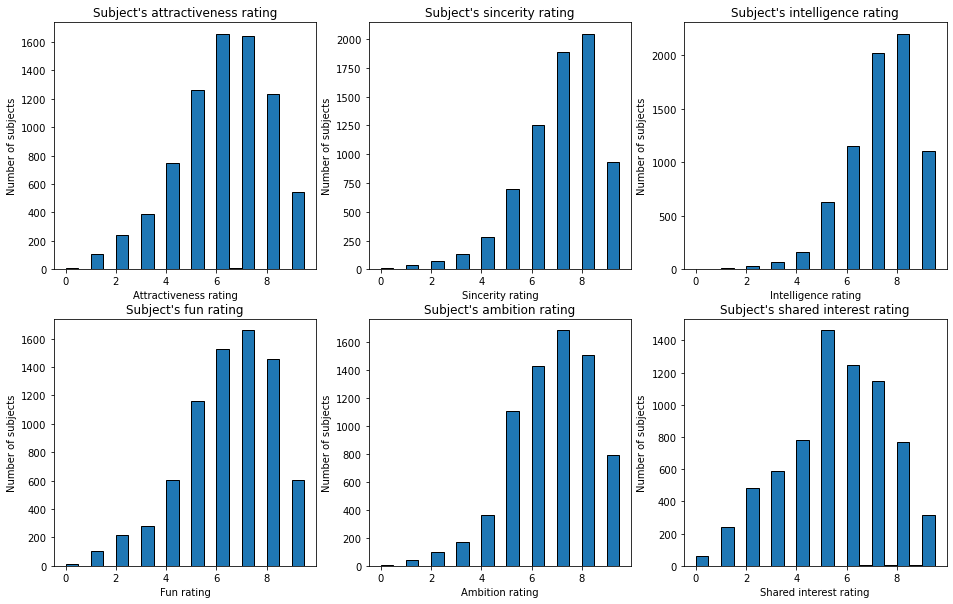

In [29]:
plt.figure(figsize=(16,10))
plt.tight_layout(pad=5.0)

plt.subplot(2,3,1)
plot_distribution(
    data=data['attr_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s attractiveness rating',
    xlabel='Attractiveness rating',
    ylabel='Number of subjects'
)
plt.subplot(2,3,2)
plot_distribution(
    data=data['sinc_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s sincerity rating',
    xlabel='Sincerity rating',
    ylabel='Number of subjects'
)
plt.subplot(2,3,3)
plot_distribution(
    data=data['intel_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s intelligence rating',
    xlabel='Intelligence rating',
    ylabel='Number of subjects'
)
plt.subplot(2,3,4)
plot_distribution(
    data=data['fun_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s fun rating',
    xlabel='Fun rating',
    ylabel='Number of subjects'
)
plt.subplot(2,3,5)
plot_distribution(
    data=data['amb_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s ambition rating',
    xlabel='Ambition rating',
    ylabel='Number of subjects'
)
plt.subplot(2,3,6)
plot_distribution(
    data=data['shar_o'],
    bins=np.arange(0, 10, 0.5).tolist(),
    title='Subject\'s shared interest rating',
    xlabel='Shared interest rating',
    ylabel='Number of subjects'
)

### Calculate the moments of subject attribute ratings from their partners

In [30]:
print_moments('Attractiveness rating', data['attr_o'])

Attractiveness rating
Mean:               6.19
Standard deviation: 1.95
Skewness:          -0.32
Kurtosis:          -0.10


In [31]:
print_moments('Sincerity rating', data['sinc_o'])

Sincerity rating
Mean:               7.18
Standard deviation: 1.74
Skewness:          -0.64
Kurtosis:           0.75


In [32]:
print_moments('Intelligence rating', data['intel_o'])

Intelligence rating
Mean:               7.37
Standard deviation: 1.55
Skewness:          -0.55
Kurtosis:           0.76


In [33]:
print_moments('Fun rating', data['fun_o'])

Fun rating
Mean:               6.40
Standard deviation: 1.95
Skewness:          -0.45
Kurtosis:           0.10


In [34]:
print_moments('Ambition rating', data['amb_o'])

Ambition rating
Mean:               6.78
Standard deviation: 1.79
Skewness:          -0.39
Kurtosis:           0.17


In [35]:
print_moments('Shared interest rating', data['shar_o'])

Shared interest rating
Mean:               5.47
Standard deviation: 2.16
Skewness:          -0.19
Kurtosis:          -0.37


Get features with highest variance

In [36]:
data.std().sort_values(ascending=False).head(10)

pid         158.584335
iid         158.583367
attr1_1      12.587790
pf_o_att     12.569827
sinc1_1       7.046759
pf_o_sin      7.044133
intel1_1      6.783009
pf_o_int      6.782840
pf_o_sha      6.362691
shar1_1       6.362234
dtype: float64

Get features with highest skew

In [37]:
abs(data.skew()).sort_values(ascending=False).head(10)

pf_o_att    2.176008
attr1_1     2.173592
match_es    1.522720
expnum      1.394183
go_out      1.204180
movies      1.081646
sinc3_1     1.080209
age_o       1.073471
age         1.069590
fun3_1      0.824947
dtype: float64

### 4.2 Bivariate analysis
* Visualise correlation between selected features

In [38]:
features_selected = [
    'dec_o',
    'pf_o_att',
    'pf_o_sin',
    'pf_o_int',
    'pf_o_fun',
    'pf_o_amb',
    'pf_o_sha',
    'attr_o',
    'sinc_o',
    'intel_o',
    'fun_o',
    'amb_o',
    'shar_o'
]

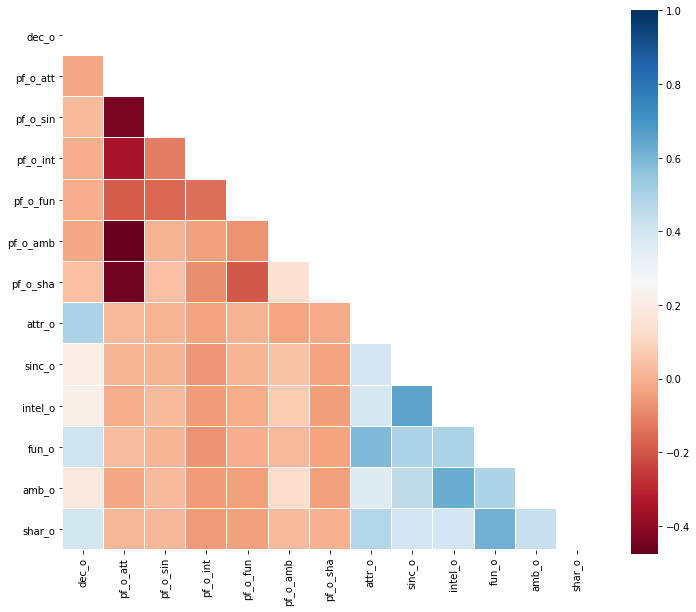

In [39]:
plt.figure(figsize=(12,10))
cmap = plt.cm.RdBu
mask = np.triu(data[features_selected].astype(float).corr())
sns.heatmap(
    data[features_selected].astype(float).corr(),
    square=True,
    cmap=cmap,
    mask=mask,
    linewidths=0.1,
    vmax=1.0,
    linecolor='white'
);

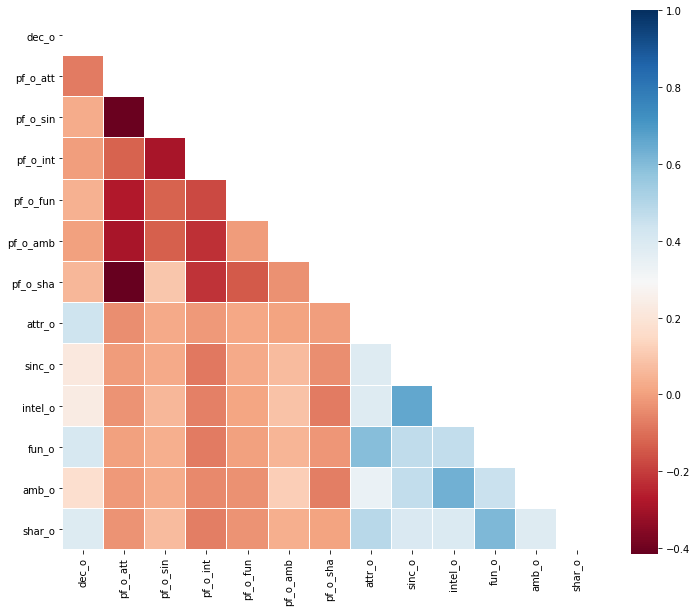

In [108]:
data_men = data[data['gender']==1]

plt.figure(figsize=(12,10))
cmap = plt.cm.RdBu
mask = np.triu(data_men[features_selected].astype(float).corr())
sns.heatmap(
    data_men[features_selected].astype(float).corr(),
    square=True,
    cmap=cmap,
    mask=mask,
    linewidths=0.1,
    vmax=1.0,
    linecolor='white'
);

Visualise correlation between selected features for women

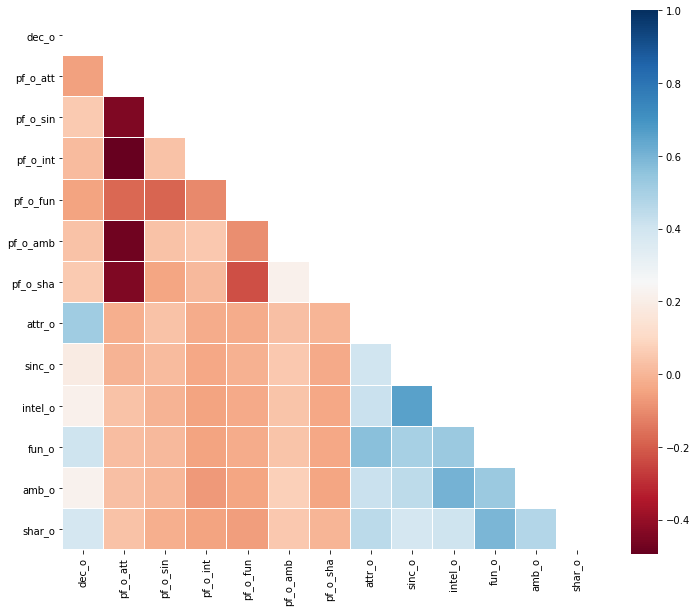

In [45]:
data_women = data[data['gender']==0]

plt.figure(figsize=(12,10))
cmap = plt.cm.RdBu
mask = np.triu(data_women[features_selected].astype(float).corr())
sns.heatmap(
    data_women[features_selected].astype(float).corr(),
    square=True,
    cmap=cmap,
    mask=mask,
    linewidths=0.1,
    vmax=1.0,
    linecolor='white'
);

In [46]:
correlations = data.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
correlations = correlations[correlations != 1]
correlations[correlations > 0.6]

iid      wave        0.996713
pid      wave        0.996712
iid      pid         0.992968
art      museums     0.858548
fun_o    like_o      0.691267
fun      like        0.691248
attr_o   like_o      0.667240
attr     like        0.667239
shar     like        0.660826
like_o   shar_o      0.660448
sinc     intel       0.657664
intel_o  sinc_o      0.657548
music    concerts    0.655728
amb      intel       0.627483
intel_o  amb_o       0.627332
shar_o   fun_o       0.617995
shar     fun         0.617989
dtype: float64

Get highest correlated features with target variable

In [47]:
partner_decision_correlations = correlations.loc['dec_o']
partner_decision_correlations[partner_decision_correlations > 0.1]

attr_o     0.486885
fun_o      0.414276
intel_o    0.216704
amb_o      0.183216
gender     0.111550
dtype: float64

## 5. Engineering
### 5.1 Sample analysis

* Get proportion of dataframe with missing samples

In [48]:
missing_samples_proportion = data.isnull().sum()/len(data)
missing_samples_proportion.sort_values(ascending=False).head(10)

expnum      0.785152
match_es    0.140010
shar_o      0.128432
shar        0.127357
numdat_2    0.112795
satis_2     0.109215
length      0.109215
amb_o       0.086178
amb         0.084984
met         0.044760
dtype: float64

Drop features with more than 50% missing samples

In [49]:
#missing_half_samples = missing_samples_proportion[missing_samples_proportion > 0.5].index.values
#data.drop(columns=missing_half_samples, inplace=True)

Impute missing samples using iterative imputer

In [50]:
imputer = IterativeImputer(
    missing_values=np.nan,
    sample_posterior=True,
    n_nearest_features=5,
    min_value=0,
    max_value=100,
    random_state=0
)
imputer.fit(data)
data_imputed = np.around(imputer.transform(data))
data = pd.DataFrame(data_imputed, columns=data.columns)
data = data.astype({feature: datatype if all(data[feature].notna().values) else 'float32' if datatype == 'int16' else datatype for (feature, datatype) in relevant_features})

### 5.2 Feature representation
Encode nominal features using one-hot encoding

In [51]:
features_nominal = data.dtypes[data.dtypes == 'category'].index.values
data = pd.get_dummies(data, prefix=features_nominal)

### 5.3 Feature interactions
Calculate the average attribute ratings for each subject

In [52]:
subject_attractiveness_mean = data[['iid', 'attr_o']].groupby(['iid']).mean()['attr_o']
subject_sincerity_mean = data[['iid', 'sinc_o']].groupby(['iid']).mean()['sinc_o']
subject_intelligence_mean = data[['iid', 'intel_o']].groupby(['iid']).mean()['intel_o']
subject_fun_mean = data[['iid', 'fun_o']].groupby(['iid']).mean()['fun_o']
subject_ambition_mean = data[['iid', 'amb_o']].groupby(['iid']).mean()['amb_o']
subject_shared_interest_mean = data[['iid', 'shar_o']].groupby(['iid']).mean()['shar_o']

Insert average attribute ratings into dataframe

In [ ]:
data = data.merge(
    right=subject_attractiveness_mean,
    how='inner',
    on='iid'
).rename(columns={
    'attr_o_x': 'attr_o',
    'attr_o_y': 'subject_attractiveness_mean'
})

data = data.merge(
    right=subject_sincerity_mean,
    how='inner',
    on='iid'
).rename(columns={
    'sinc_o_x': 'sinc_o',
    'sinc_o_y': 'subject_sincerity_mean'
})

data = data.merge(
    right=subject_intelligence_mean,
    how='inner',
    on='iid'
).rename(columns={
    'intel_o_x': 'intel_o',
    'intel_o_y': 'subject_intelligence_mean'
})

data = data.merge(
    right=subject_fun_mean,
    how='inner',
    on='iid'
).rename(columns={
    'fun_o_x': 'fun_o',
    'fun_o_y': 'subject_fun_mean'
})

data = data.merge(
    right=subject_ambition_mean,
    how='inner',
    on='iid'
).rename(columns={
    'amb_o_x': 'amb_o',
    'amb_o_y': 'subject_ambition_mean'
})

data = data.merge(
    right=subject_shared_interest_mean,
    how='inner',
    on='iid'
).rename(columns={
    'shar_o_x': 'shar_o',
    'shar_o_y': 'subject_shared_interest_mean'
})

Calculate difference between subject and partner's ages

In [53]:
data['age_difference'] = abs(data['age'] - data['age_o'])

Calculate difference between subject's attribute ratings and partner's attributes ratings

In [54]:
data['attractiveness_difference'] = abs(data['attr'] - data['attr_o'])
data['sincerity_difference'] = abs(data['sinc'] - data['sinc_o'])
data['intelligence_difference'] = abs(data['intel'] - data['intel_o'])
data['fun_difference'] = abs(data['fun'] - data['fun_o'])
data['ambition_difference'] = abs(data['amb'] - data['amb_o'])
data['shared_interest_difference'] = abs(data['shar'] - data['shar_o'])

### 5.4 Feature transformations

Scale normal features to zero mean and unit variance

In [56]:
features_normal = [
    'attr_o',
    'sinc_o',
    'intel_o',
    'fun_o',
    'amb_o',
    'shar_o',
    'age_difference',
    'attractiveness_difference',
    'sincerity_difference',
    'intelligence_difference',
    'fun_difference',
    'ambition_difference',
    'shared_interest_difference'
]

In [57]:
data[features_normal] = data[features_normal].apply(lambda x: preprocessing.scale(x))

### 5.5 Feature selection

Drop irrelevant features which contain no information about the target variable

In [58]:
features_no_information = [
    'iid',
    'pid',
    'wave',
    'position',
    'order'
]

Drop features that are known in the future

In [60]:
features_future_information = [
    'dec',
    'dec_o',
    'like',
    'prob',
    'like_o',
    'prob_o'
]

Drop features that have low variance

In [63]:
feature_variances = data.std().sort_values(ascending=True)
features_low_variance = feature_variances[feature_variances < 0.1].index.values.tolist()

In [65]:
features_low_variance  # 분산이 낮은 features들 선택

['met_o',
 'race_0.0',
 'race_o_0.0',
 'career_c_0.0',
 'race_o_5.0',
 'race_5.0',
 'goal_0.0',
 'field_cd_17.0',
 'career_c_17.0',
 'career_c_14.0',
 'field_cd_12.0',
 'career_c_12.0',
 'field_cd_16.0',
 'career_c_16.0',
 'career_c_8.0',
 'field_cd_18.0',
 'career_c_15.0',
 'career_c_13.0']

Drop features that have weak correlation with target variable

In [66]:
features_weak_correlation = partner_decision_correlations[partner_decision_correlations < 0.1].axes[0].to_list()
features_weak_correlation = list(set(features_weak_correlation) - set(features_future_information) - set(features_no_information))

In [67]:
features_weak_correlation

['concerts',
 'tv',
 'gaming',
 'museums',
 'pf_o_int',
 'attr',
 'intel1_1',
 'imprelig',
 'amb1_1',
 'sinc3_1',
 'shopping',
 'clubbing',
 'intel3_1',
 'met',
 'amb3_1',
 'sinc1_1',
 'dining',
 'date',
 'shar1_1',
 'numdat_2',
 'attr3_1',
 'fun3_1',
 'pf_o_sin',
 'music']

Drop features that were used in interaction variables

In [68]:
features_interaction = [
    'age',
    'age_o',
]

In [69]:
features_remove = features_no_information+features_future_information+features_low_variance+features_weak_correlation+features_interaction
data_model = data.drop(columns=features_remove)

### 5.6 Data export

Persist dataframe containing features to be used in model

In [72]:
data_model.to_csv(
    path_or_buf='./data_model.csv',
    index=False
)

# 6. Modelling

### 6.1 Baseline models
* Define feature and target variables

In [141]:
data_model[''].value_counts()

7     1635
8     1349
9     1204
5      979
6      961
10     890
4      541
3      458
2      193
1      147
0       18
12       2
11       1
Name: theater, dtype: int64

In [132]:
data_model.columns

Index(['gender', 'pf_o_att', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'imprace', 'go_out',
       'sports', 'tvsports', 'exercise', 'art', 'hiking', 'reading', 'theater',
       'movies', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'fun1_1', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'match_es', 'satis_2', 'length',
       'race_o_1.0', 'race_o_2.0', 'race_o_3.0', 'race_o_4.0', 'race_o_6.0',
       'field_cd_1.0', 'field_cd_2.0', 'field_cd_3.0', 'field_cd_4.0',
       'field_cd_5.0', 'field_cd_6.0', 'field_cd_7.0', 'field_cd_8.0',
       'field_cd_9.0', 'field_cd_10.0', 'field_cd_11.0', 'field_cd_13.0',
       'field_cd_14.0', 'field_cd_15.0', 'race_1.0', 'race_2.0', 'race_3.0',
       'race_4.0', 'race_6.0', 'goal_1.0', 'goal_2.0', 'goal_3.0', 'goal_4.0',
       'goal_5.0', 'goal_6.0', 'career_c_1.0', 'career_c_2.0', 'career_c_3.0',
       'career_c_4.0', 'career_c_5.0', 'career_c_6.0', 'career_c_7.0',
       'career_c_9.0',

In [119]:
features = data_model  # 학습할 features (x)
target = data['dec_o'] # 정답값 (y)

In [126]:
race_features = ['race_o_1.0', 'race_o_2.0', 'race_o_3.0', 'race_o_4.0', 'race_o_6.0',
                 'race_1.0', 'race_2.0', 'race_3.0', 'race_4.0', 'race_6.0']

In [129]:
features = features.drop(columns=race_features)

In [130]:
features.columns

Index(['gender', 'pf_o_att', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'imprace', 'go_out',
       'sports', 'tvsports', 'exercise', 'art', 'hiking', 'reading', 'theater',
       'movies', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'fun1_1', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'match_es', 'satis_2', 'length',
       'field_cd_1.0', 'field_cd_2.0', 'field_cd_3.0', 'field_cd_4.0',
       'field_cd_5.0', 'field_cd_6.0', 'field_cd_7.0', 'field_cd_8.0',
       'field_cd_9.0', 'field_cd_10.0', 'field_cd_11.0', 'field_cd_13.0',
       'field_cd_14.0', 'field_cd_15.0', 'goal_1.0', 'goal_2.0', 'goal_3.0',
       'goal_4.0', 'goal_5.0', 'goal_6.0', 'career_c_1.0', 'career_c_2.0',
       'career_c_3.0', 'career_c_4.0', 'career_c_5.0', 'career_c_6.0',
       'career_c_7.0', 'career_c_9.0', 'career_c_10.0', 'career_c_11.0',
       'age_difference', 'attractiveness_difference', 'sincerity_difference',
       'intelligence_difference

In [77]:
parameters = {
    'penalty': ['l2'],       # 정규화
    'solver': ['lbfgs'],     
    'C': np.logspace(-4, 4, 20),
    'max_iter': [10000]
}
classifier_lr = LogisticRegression(random_state=0)
classifier_lr = GridSearchCV(
    estimator=classifier_lr,
    param_grid=parameters, 
    cv=5,      # 교차 검증을 5개의 데이터셋으로 나누세요
    verbose=2, # 훈련 과정을 보여주세요
    n_jobs=-1  # 활용할 수 있는 최대의 스레드를 사용하세요
)
classifier_lr.fit(features, target)
classifier_lr.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.5s finished


{'C': 0.03359818286283781,
 'max_iter': 10000,
 'penalty': 'l2',
 'solver': 'lbfgs'}

Instantiate, train and tune a linear model

In [78]:
classifier_lr = LogisticRegression(
    random_state=0,
    penalty=classifier_lr.best_params_['penalty'],
    solver=classifier_lr.best_params_['solver'],
    C=classifier_lr.best_params_['C'],
    max_iter=classifier_lr.best_params_['max_iter']
)

In [80]:
classifier_lr  # 로지스틱 regrssion ( 0~ 1 prob)

LogisticRegression(C=0.03359818286283781, max_iter=10000, random_state=0)

Instantiate, train and tune a discriminative model

In [81]:
parameters = {
    'kernel': ['rbf'],
    'gamma': [1e-4, 1e-3, 1e-2],
    'C': [1, 10, 100, 1000]
}
classifier_sv = SVC(random_state=0)
classifier_sv = GridSearchCV(
    estimator=classifier_sv,
    param_grid=parameters,
    cv=5,
    verbose=2,
    n_jobs=-1
)
classifier_sv.fit(features, target)
classifier_sv.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [82]:
classifier_sv = SVC(
    random_state=0,
    kernel=classifier_sv.best_params_['kernel'],
    gamma=classifier_sv.best_params_['gamma'],
    C=classifier_sv.best_params_['C']
)

Instantiate, train and tune a instance-based model

In [83]:
parameters = {
    'n_neighbors': [5,11,19,29],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}
classifier_kn = KNeighborsClassifier()
classifier_kn = GridSearchCV(
    estimator=classifier_kn,
    param_grid=parameters,
    cv=5,
    verbose=2,
    n_jobs=-1
)
classifier_kn.fit(features, target)
classifier_kn.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   30.5s finished


{'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}

In [84]:
classifier_kn = KNeighborsClassifier(
    n_neighbors=classifier_kn.best_params_['n_neighbors'],
    weights=classifier_kn.best_params_['weights'],
    metric=classifier_kn.best_params_['metric']
)

### 6.2 Ensemble models

In [85]:
parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}
classifier_gb = GradientBoostingClassifier(random_state=0)
classifier_gb = GridSearchCV(
    estimator=classifier_gb,
    param_grid=parameters,
    cv=5,
    verbose=2,
    n_jobs=-1
)
classifier_gb.fit(features, target)
classifier_gb.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   20.6s finished


{'learning_rate': 0.05,
 'loss': 'exponential',
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [86]:
classifier_gb = GradientBoostingClassifier(
    random_state=0,
    loss=classifier_gb.best_params_['loss'],
    learning_rate=classifier_gb.best_params_['learning_rate'],
    n_estimators=classifier_gb.best_params_['n_estimators'],
    max_depth=classifier_gb.best_params_['max_depth'],
    max_features=classifier_gb.best_params_['max_features']
)

Instantiate and train a voting and stacking model

In [90]:
estimators = [
    ('lr', classifier_lr), # logistic regression 
    ('sv', classifier_sv), # support vector classifier
    ('kn', classifier_kn), # k-neighbors
    ('gb', classifier_gb)  # grandient boosting
]

In [91]:
# voting 방식 -> 위의 4가지 얘들 중에서 투표를 해! 그래서 많이 뽑힌 애 반장해
classifier_ve = VotingClassifier(
    estimators=estimators,
    voting='hard' # 다수결 투표!
)

In [92]:
# 스태킹 방법(일종의 앙상블)-> 4개를 순차적으로 해! (먼저 1번 투표해!) 2번 투표해! 3번 투포해! 4번 해!
classifier_se = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

# 7 Evaluation
### 7.1 Classifier performance
* Calculate performance metrics for each model

In [98]:
features.columns

Index(['gender', 'pf_o_att', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'attr_o',
       'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'imprace', 'go_out',
       'sports', 'tvsports', 'exercise', 'art', 'hiking', 'reading', 'theater',
       'movies', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'fun1_1', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'match_es', 'satis_2', 'length',
       'race_o_1.0', 'race_o_2.0', 'race_o_3.0', 'race_o_4.0', 'race_o_6.0',
       'field_cd_1.0', 'field_cd_2.0', 'field_cd_3.0', 'field_cd_4.0',
       'field_cd_5.0', 'field_cd_6.0', 'field_cd_7.0', 'field_cd_8.0',
       'field_cd_9.0', 'field_cd_10.0', 'field_cd_11.0', 'field_cd_13.0',
       'field_cd_14.0', 'field_cd_15.0', 'race_1.0', 'race_2.0', 'race_3.0',
       'race_4.0', 'race_6.0', 'goal_1.0', 'goal_2.0', 'goal_3.0', 'goal_4.0',
       'goal_5.0', 'goal_6.0', 'career_c_1.0', 'career_c_2.0', 'career_c_3.0',
       'career_c_4.0', 'career_c_5.0', 'career_c_6.0', 'career_c_7.0',
       'career_c_9.0',

In [93]:
# 평가 지표!
metrics = ['accuracy', 'precision', 'recall', 'f1_macro']

# 하나씩 평가 해 봅시다.
# 1. 로지스틱 회귀
# 2. SV
# 3. KNN
# 4. GB ()
# 5. VE (투표 방식 Hard)
# 6. SE (스태킹!)
for classifier, label in zip(
    [classifier_lr, classifier_sv, classifier_kn, classifier_gb, classifier_ve, classifier_se],
    ['Logistic Regression', 'Support Vector Machine', 'k-Nearest Neighbours', 'Gradient Boosting', 'Voting Ensemble', 'Stacking Ensemble']
):
    print('{}'.format(label))
    scores = cross_validate(
        estimator=classifier,
        X=features,
        y=target,
        scoring=metrics,
        cv=5,
        n_jobs=-1
    )
    for key, value in scores.items():
        print('{:14} {:.3f} +/- {:.3f}'.format(key, value.mean(), value.std()))
    print('\n')

Logistic Regression
fit_time       0.844 +/- 0.133
score_time     0.010 +/- 0.001
test_accuracy  0.750 +/- 0.017
test_precision 0.717 +/- 0.030
test_recall    0.669 +/- 0.038
test_f1_macro  0.740 +/- 0.017


Support Vector Machine
fit_time       4.546 +/- 0.108
score_time     0.526 +/- 0.029
test_accuracy  0.739 +/- 0.019
test_precision 0.699 +/- 0.031
test_recall    0.667 +/- 0.025
test_f1_macro  0.730 +/- 0.019


k-Nearest Neighbours
fit_time       0.078 +/- 0.003
score_time     1.849 +/- 0.023
test_accuracy  0.644 +/- 0.020
test_precision 0.605 +/- 0.042
test_recall    0.460 +/- 0.044
test_f1_macro  0.618 +/- 0.015


Gradient Boosting
fit_time       0.614 +/- 0.002
score_time     0.013 +/- 0.000
test_accuracy  0.750 +/- 0.017
test_precision 0.718 +/- 0.038
test_recall    0.673 +/- 0.027
test_f1_macro  0.741 +/- 0.016


Voting Ensemble
fit_time       6.292 +/- 0.105
score_time     2.335 +/- 0.019
test_accuracy  0.745 +/- 0.012
test_precision 0.735 +/- 0.030
test_recall    0.618 +/- 0

## 7.2 Feature importance
* Get coefficients of features in linear model

In [94]:
labels = features.columns.values
weights = classifier_lr.fit(features,target).coef_[0]

* Get features with highest magnitude

In [95]:
top_features = sorted(list(zip(labels,weights)), reverse=True, key = lambda x: abs(x[1]))[0:10]
top_labels = [x[0] for x in top_features]
top_weights = [x[1] for x in top_features]

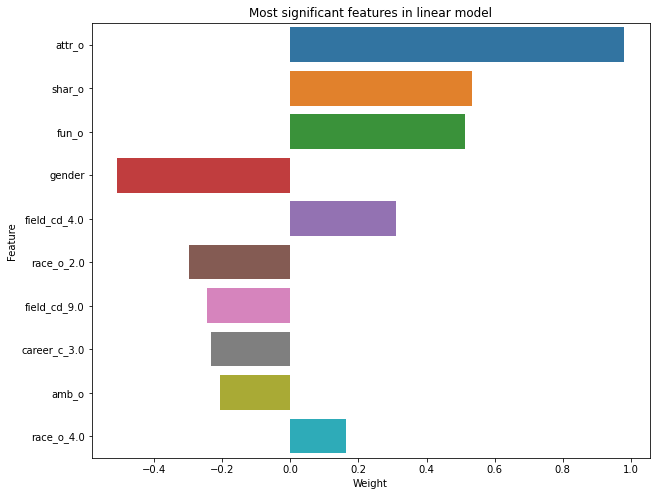

In [96]:
plt.figure(figsize=(10,8))
plot_relationship(top_weights, top_labels, 'Most significant features in linear model', 'Weight', 'Feature')

# 8 Conclusion

This notebook explored whether a machine learning model could predict if a partner will match with their date.
The best performing classifier was a stacking ensemble model with an accuracy of ~76% and an F1 score of ~75%.
Based on correlation analysis and weights in the linear model:
Attractiveness, shared interests and being fun were the most significant factors in a partner's decision.
Medical students had the highest probability of being matched while psychologists and academics had the lowest.
Further feature engineering such as introducing more interaction features and performing more thorough feature selection could improve the classifier performance.ㅡ